#                                                Rédolutuion de l'équation de Laplace

## Résolution avec différence finie

2999


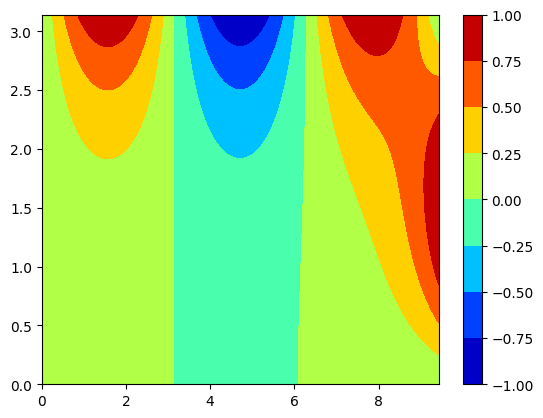

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain and grid spacing
Lx = 3 * np.pi
Ly = np.pi
Nx = 200
Ny = 100
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Initialize the solution array and set boundary conditions
u = np.zeros((Nx, Ny))
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
u[:, 0] = 0
u[0, :] = 0
u[:, -1] = np.sin(x)
u[-1, :] = np.sin(y)


max_iter = 3000  
tol = 1e-5  # Tolerance for convergence
for h in range(max_iter):
    u_new = u.copy()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            u_new[i, j] = ((u[i+1, j] + u[i-1, j]) * dy**2 +
                           (u[i, j+1] + u[i, j-1]) * dx**2) / (2 * (dx**2 + dy**2))
    # Check for convergence
    if np.linalg.norm(u - u_new, ord=np.inf) < tol:
        break
    u = u_new

# Plot the solution
X, Y = np.meshgrid(x, y)
print(h)
plt.contourf(X, Y, u.T, cmap='jet')
plt.colorbar()
plt.show()


### creating a fully connected network


In [195]:

import torch 
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        

        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

Epoch 0, Loss 1.2651103734970093
Epoch 100, Loss 0.14821398258209229
Epoch 200, Loss 0.06220109760761261
Epoch 300, Loss 0.03263193741440773
Epoch 400, Loss 0.030023973435163498
Epoch 500, Loss 0.0008573610102757812
Epoch 600, Loss 0.00044550769962370396
Epoch 700, Loss 0.001201370032504201
Epoch 800, Loss 0.004271375946700573
Epoch 900, Loss 0.005790292285382748


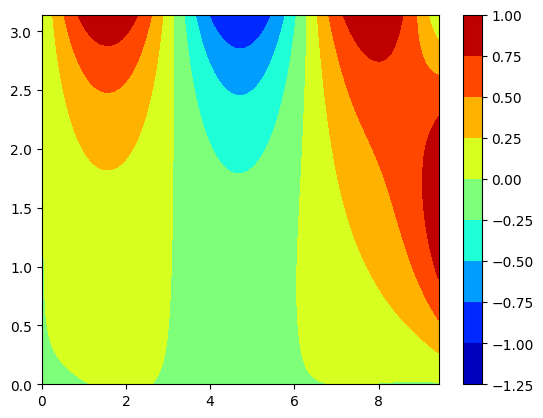

In [147]:
import torch as tf



pinn2 = Net(2, 1, 30, 6)

def ui(x, y , pinn):
    return pinn(tf.concat((x, y), dim=1))

# defining the pde (Laplace)
def f(x, y ,pinn):
    u = ui(x, y ,pinn)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    return u_xx + u_yy

#initial and boundary conditions losses
def loss_boundary_1(x , pinn):
    return tf.mean((ui(x , torch.zeros_like(x) ,pinn)**2))
def loss_boundary_2(x,pinn):
    return tf.mean((ui(x , torch.ones_like(x)*np.pi,pinn) - np.sin(x))**2)

def loss_boundary_3(y,pinn):
    return tf.mean((ui( torch.ones_like(y)*np.pi*3,y,pinn) - np.sin(y))**2)
def loss_boundary_4(y ,pinn):
    return tf.mean((ui( torch.zeros_like(y),y ,pinn) )**2)
 

# pde loss
def loss_fn(x, y ,pinn):
    
    x.requires_grad_(True)
    y.requires_grad_(True)
    
    f_pred = f(x, y ,pinn)
    return torch.mean((f_pred )**2) 





x = torch.linspace(0, 3 * np.pi, 100)
y = torch.linspace(0, np.pi, 100)



x,y = tf.meshgrid(x,y)
optimizer = torch.optim.Adam(pinn2.parameters(), lr=0.01)
for epoch in range(600):
    optimizer.zero_grad()
    loss2 = loss_boundary_1(x.flatten().unsqueeze(1) , pinn2)
    loss3 = loss_boundary_2(x.flatten().unsqueeze(1) ,pinn2)
    loss4 = loss_boundary_3(y.flatten().unsqueeze(1) , pinn2)
    loss5 = loss_boundary_4(y.flatten().unsqueeze(1) , pinn2)

    loss = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2) + loss2 + loss3 + loss4 + loss5
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')


u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),pinn2)
plt.contourf(x, y, u_pred.detach().numpy().reshape(100,100), cmap='jet')
plt.colorbar()
plt.show()

### choosing the best number of layers and neurons 

In [159]:



def ecaluate(Models , x, y , Nb_epochs , learning_rate):
    x,y = tf.meshgrid(x,y)
    scores = []
    for model in Models:
       
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(Nb_epochs):
            optimizer.zero_grad()
            loss2 = loss_boundary_1(x.flatten().unsqueeze(1) ,model)
            loss3 = loss_boundary_2(x.flatten().unsqueeze(1),model)
            loss4 = loss_boundary_3(y.flatten().unsqueeze(1),model)
            loss5 = loss_boundary_4(y.flatten().unsqueeze(1),model)

            loss = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),model) + loss2 + loss3 + loss4 + loss5
            loss.backward()
            optimizer.step()
        print(loss)
        scores.append(loss.item())

    return scores





In [160]:
learning_rate = 0.01
Nb_neurons = [10, 20, 30, 40, 50]
Nb_layers = [2, 3, 4, 5, 6]
Models = [Net(2, 1, n, l) for n in Nb_neurons for l in Nb_layers]
x = torch.linspace(0, 3 * np.pi, 100)   
y = torch.linspace(0, np.pi, 100)

scores = ecaluate(Models, x, y, 600, learning_rate)

tensor(0.0819, grad_fn=<AddBackward0>)
tensor(0.1013, grad_fn=<AddBackward0>)
tensor(0.0738, grad_fn=<AddBackward0>)
tensor(0.1038, grad_fn=<AddBackward0>)
tensor(0.0338, grad_fn=<AddBackward0>)
tensor(0.1026, grad_fn=<AddBackward0>)
tensor(0.0195, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)
tensor(0.0097, grad_fn=<AddBackward0>)
tensor(0.0228, grad_fn=<AddBackward0>)
tensor(0.0329, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0021, grad_fn=<AddBackward0>)
tensor(0.0135, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0020, grad_fn=<AddBackward0>)
tensor(0.0017, grad_fn=<AddBackward0>)
tensor(0.0228, grad_fn=<AddBackward0>)
tensor(0.0366, grad_fn=<AddBackward0>)
tensor(0.0265, grad_fn=<AddBackward0>)
tensor(0.0130, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)
tensor(0.0416, grad_fn=<AddBackward0>)


In [161]:
best_model = Models[np.argmin(scores)]
print(best_model)

Net(
  (f1): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
  )
  (f2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
  )
  (f3): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),best_model)
plt.contourf(x, y, u_pred.detach().numpy().reshape(100,100), cmap='jet')
plt.colorbar()
plt.show()


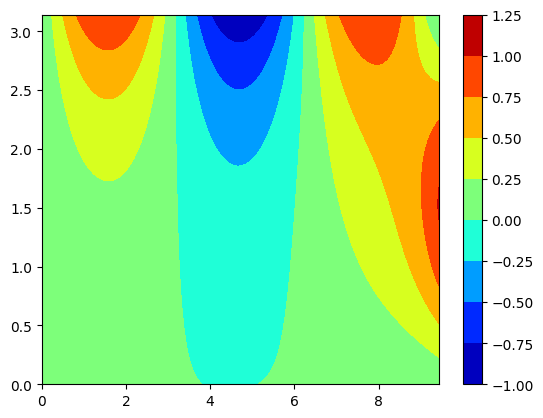

In [194]:

u_pred = ui(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),best_model)
plt.contourf(x, y, u_pred.detach().numpy().reshape(100,100), cmap='jet')
plt.colorbar()
plt.show()

### choosing the best weights for the Loss function

In [196]:
def evaluate_loss(model ,x,y, W_i ,W_bc):
    x,y = tf.meshgrid(x,y)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(600):
        optimizer.zero_grad()
        loss2 = loss_boundary_1(x.flatten().unsqueeze(1) , model)
        loss3 = loss_boundary_2(x.flatten().unsqueeze(1),model)
        loss4 = loss_boundary_3(y.flatten().unsqueeze(1),model)
        loss5 = loss_boundary_4(y.flatten().unsqueeze(1),model)

        loss6 = loss_fn(x.flatten().unsqueeze(1), y.flatten().unsqueeze(1),model) 
        loss = loss6 + W_i*(loss2 + loss4 ) + W_bc*(loss3 + loss5)
        loss.backward()
        optimizer.step()
    return loss.item()

In [199]:
Wi = [0.1, 1, 10, 100]
Wbc = [0.1, 1, 10, 100]

losses = []
x = torch.linspace(0, 3 * np.pi, 100)
y = torch.linspace(0, np.pi, 100)

for w_i in Wi:
    for w_bc in Wbc:
        loss = evaluate_loss(best_model, x, y, w_i, w_bc)
        losses.append(loss)

In [200]:
best_Wi = Wi[np.argmin(losses) // len(Wbc)]
best_Wbc = Wbc[np.argmin(losses) % len(Wbc)]

print(f'Best Wi: {best_Wi}, Best Wbc: {best_Wbc}')

Best Wi: 0.1, Best Wbc: 1
